# About our data
Our data is about English health, specifically information of patients, tumours and treatments. 
All the data is in tabular type (CSV files).

In [65]:
# import packages...
from pandas import Series, DataFrame
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Describe: sim_sact_drug_detail.csv
Let's have a look at this table.

In [66]:
# read table sim_sact_drug_detail
drug = pd.read_csv('sim_sact_drug_detail.csv', delimiter=',')
drug.head()

,MERGED_DRUG_DETAIL_ID,MERGED_CYCLE_ID,ORG_CODE_OF_DRUG_PROVIDER,ACTUAL_DOSE_PER_ADMINISTRATION,OPCS_DELIVERY_CODE,ADMINISTRATION_ROUTE,ADMINISTRATION_DATE,DRUG_GROUP,MERGED_PATIENT_ID,MERGED_TUMOUR_ID,MERGED_REGIMEN_ID
0,10000001,10000001,EKD02,10.0,NaN,1.0,2015-06-07,STEROID,10000235,10000001,10000001
1,10000002,10000002,EGU02,30.0,NaN,2.0,NaN,NOT CHEMO,10000315,10000002,10000002
2,10000003,10000003,EGU05,1000.0,NaN,1.0,NaN,RITUXIMAB,10000337,10000003,10000003
3,10000004,10000004,EXO,8.0,X723,2.0,2015-03-23,NOT CHEMO,10000480,10000004,10000004
4,10000005,10000005,ETD02,1000.0,NaN,2.0,2013-03-11,NOT CHEMO,10000533,10000005,10000005


In [67]:
# get the shape of the table
print(drug.shape)
print(drug.columns.values)

(3544584, 11)
['MERGED_DRUG_DETAIL_ID' 'MERGED_CYCLE_ID' 'ORG_CODE_OF_DRUG_PROVIDER'
 'ACTUAL_DOSE_PER_ADMINISTRATION' 'OPCS_DELIVERY_CODE'
 'ADMINISTRATION_ROUTE' 'ADMINISTRATION_DATE' 'DRUG_GROUP'
 'MERGED_PATIENT_ID' 'MERGED_TUMOUR_ID' 'MERGED_REGIMEN_ID']


 
This table contains 3544584 rows and 11 columns, which are about the details of drugs used in patients including dosages, categories, drug providers and information about administrations.
The columns are:

- MERGED_DRUG_DETAIL_ID: unique id of drug details. Type: int
- MERGED_CYCLE_ID: foreign key of cycles(in sim_sact_cycle.csv). Type: int
- ORG_CODE_OF_DRUG_PROVIDER: organization codes of drug providers. Type: string
- ACTUAL_DOSE_PER_ADMINISTRATION: actual dosages per administration. Type: float
- OPCS_DELIVERY_CODE: OPCS delivery codes. Type: string
- ADMINISTRATION_ROUTE: routes of administration. Type: float
- ADMINISTRATION_DATE: dates of administration. Type: string
- DRUG_GROUP: group names of drug. Type: string
- MERGED_PATIENT_ID: foreign key of patients(sim_sact_patient.csv). Type: int
- MERGED_TUMOUR_ID: foreign key of tumours(sim_sact_tumour.csv). Type: int
- MERGED_REGIMEN_ID: foreign key of regimens(sim_sact_regimen.csv). Type: int

Reference information:

* [What is administration routes](https://en.wikipedia.org/wiki/Route_of_administration)
* [Administration Routes Code](https://www.datadictionary.nhs.uk/data_dictionary/attributes/s/sup/systemic_anti-cancer_therapy_drug_route_of_administration_de.asp?shownav=1?query=%22route+of+administration%22&rank=66.66667&shownav=1)
* [organisation code of drug provider](https://www.datadictionary.nhs.uk/data_dictionary/attributes/o/org/organisation_code_de.asp?shownav=1)

# Data Cleaning: sim_sact_drug_detail.csv
1. Because some entries are with invalid codes of administration routes, I cleaned these entries.

In [68]:
drug = drug.loc[(drug['ADMINISTRATION_ROUTE']>0.0) & (drug['ADMINISTRATION_ROUTE']<=14.0) | 
                (drug['ADMINISTRATION_ROUTE']==99.0)]

2. Because actual dosages per administration can not be negative, so I cleaned those entries with value below zero.

In [69]:
drug = drug.loc[drug['ACTUAL_DOSE_PER_ADMINISTRATION']>=0]

3. Because actual dosages per administration should be integers, so I converted all the values into type 'int'.

In [70]:
drug['ACTUAL_DOSE_PER_ADMINISTRATION'] = drug['ACTUAL_DOSE_PER_ADMINISTRATION'].astype('int')

4. I deleted all the entries with null values.

In [71]:
drug.dropna(axis=0, how='any', inplace=True)

# Explore: sim_sact_drug_detail.csv

## Simple statistics

1. The maximum value of dosages per administration is:

In [72]:
np.max(drug['ACTUAL_DOSE_PER_ADMINISTRATION'])

1801201

2. The minimum value of dosages per administration is:

In [73]:
np.min(drug['ACTUAL_DOSE_PER_ADMINISTRATION'])

0

## Drug Group Information
Because some drug groups have too small sizes, I included all the drug groups having amount below 40000 in category 'OTHERS'.

In [74]:
drug_groups = drug['DRUG_GROUP'].value_counts()

# add all drug groups having amount below 40000 to OTHERS
drug_groups_others_num = np.sum(drug_groups.loc[drug_groups<40000])
drug_groups_others = pd.Series([int(drug_groups_others_num)], index=['OTHERS'])
drug_groups = drug_groups.loc[drug_groups>=40000]
drug_groups = drug_groups.append(drug_groups_others)

The bar chart below shows amount of different drug groups.

**What I've found:** 
From this bar chart, we can clearly see the most frequently used drug group is NOT CHEMO and this drug group is at a much higher frequency used than other drug groups.

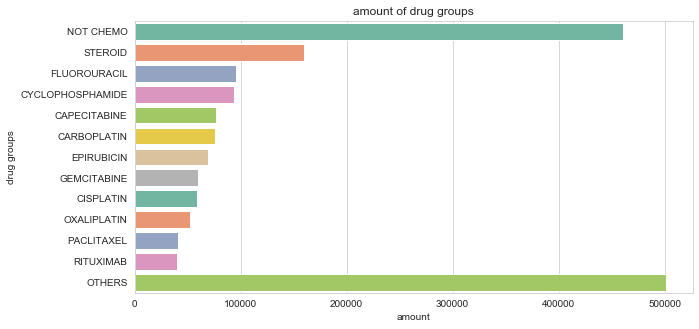

In [75]:
# plot
fig1, ax1 = plt.subplots(figsize=(10,5))
sns.set_style("whitegrid")
ax1.set_ylabel("drug groups")
ax1.set_xlabel("amount")
ax1.set_title("amount of drug groups")
ax1 = sns.barplot(x=drug_groups.values, y=drug_groups.index.values, palette="Set2")
plt.show()

## Administration Route Information
The pie chart below shows proportion of different administration routes. To make the small proportions more visible, a right subplot is ploted showing administration routes excluding Intravenous, Oral and Subcutaneous.

**What I've found:** 
Intravenous constitutes the largest proportion of administration routes. And Oral and Subcutaneous are respectively the secondly and thirdly largest parts. Other administration routes are much smaller compositions of the whole, which may be easily neglected.

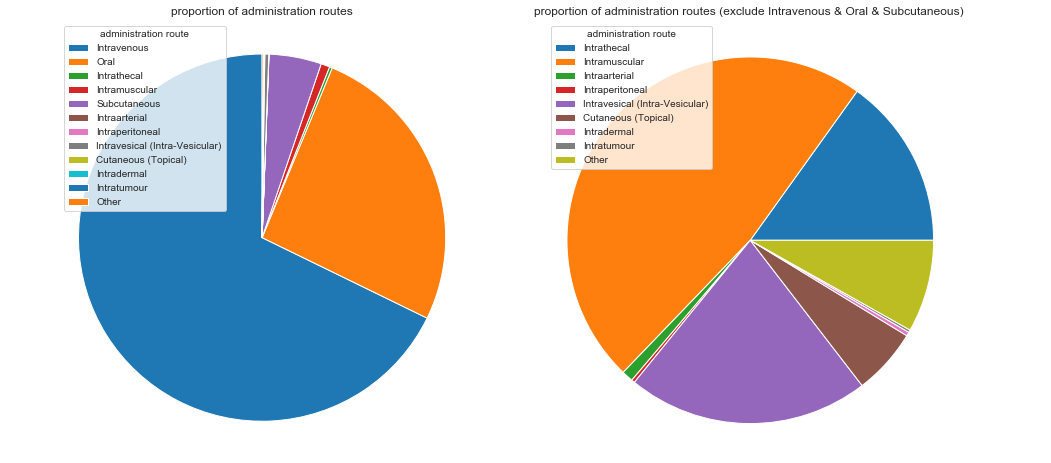

In [76]:
admin_routes_groupby = drug.groupby(['ADMINISTRATION_ROUTE'])
admin_routes = admin_routes_groupby.count()

# Pie chart
admin_route_labels = [ 'Intravenous', 
                       'Oral',
                       'Intrathecal', 
                       'Intramuscular', 
                       'Subcutaneous', 
                       'Intraarterial', 
                       'Intraperitoneal', 
                       'Intravesical (Intra-Vesicular)', 
                       'Cutaneous (Topical)', 
                       'Intradermal', 
                       'Intratumour', 
                       'Other' ]
admin_route_sizes = list(admin_routes['MERGED_DRUG_DETAIL_ID'])

# plot
fig2, ax2 = plt.subplots(1, 2, figsize=(16,8))
explode = (0,0,0,0,0,0,0,0,0,0,0,0)
ax2[0].pie(admin_route_sizes,
        explode=explode,
        labels=admin_route_labels,
        shadow = False,
        startangle =90,
        pctdistance = 0.6,
        textprops={'fontsize': 16, 'color':'w'})
ax2[0].legend(admin_route_labels, loc='best', title='administration route')
ax2[0].axis('equal')
ax2[0].set_title("proportion of administration routes")

admin_route_labels_ = [ 'Intrathecal', 
                        'Intramuscular', 
                        'Intraarterial', 
                        'Intraperitoneal', 
                        'Intravesical (Intra-Vesicular)', 
                        'Cutaneous (Topical)', 
                        'Intradermal', 
                        'Intratumour', 
                        'Other' ]
admin_route_sizes_ = admin_route_sizes[2:4]
admin_route_sizes_.extend(admin_route_sizes[5:])
explode = (0,0,0,0,0,0,0,0,0)
ax2[1].pie(admin_route_sizes_,
        explode=explode,
        labels=admin_route_labels_,
        shadow = False,
        startangle =0,
        pctdistance = 0.6,
        textprops={'fontsize': 16, 'color':'w'})
ax2[1].legend(admin_route_labels_, loc='best', title='administration route')
ax2[1].axis('equal')
ax2[1].set_title("proportion of administration routes (exclude Intravenous & Oral & Subcutaneous)")

plt.show()

## The relation between dosages and administration routes
The bar chart below shows the average dosages per administration of every administration route.

**What I've found:** 
From the bar chart, we can see Intraaterial is related to the highest average dosage, and Intratumour is related to the lowest one. Different administration routes lead to different plans of dosages.

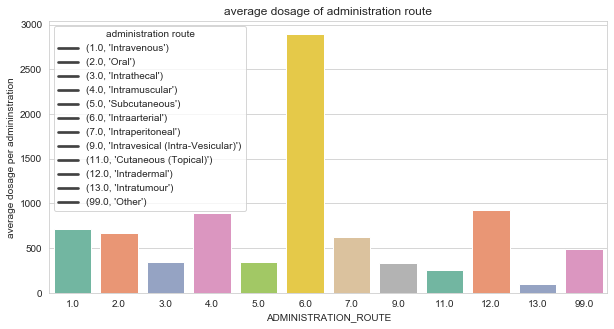

In [77]:
ave_dosage_adminRoute = admin_routes_groupby.mean()['ACTUAL_DOSE_PER_ADMINISTRATION']

# plot
fig3, ax3 = plt.subplots(figsize=(10,5))
sns.set_style("whitegrid")
ax3.set_ylabel("average dosage per admininstration")
ax3.set_xlabel("administration route")
ax3.set_title("average dosage of administration route")
ax3 = sns.barplot(x=ave_dosage_adminRoute.index, y=ave_dosage_adminRoute.values, palette="Set2")
ax3.legend(list(zip(ave_dosage_adminRoute.index,admin_route_labels)), loc='best', title='administration route')
plt.show()

# Describe: sim_sact_cycle.csv
Let's have a look at this table.

In [78]:
# read table sim_sact_cycle
cycle = pd.read_csv('sim_sact_cycle.csv', delimiter=',', low_memory=False)
cycle.head()

,MERGED_CYCLE_ID,MERGED_REGIMEN_ID,CYCLE_NUMBER,START_DATE_OF_CYCLE,OPCS_PROCUREMENT_CODE,PERF_STATUS_START_OF_CYCLE,MERGED_PATIENT_ID,MERGED_TUMOUR_ID
0,10000001,10000001,4,2015-06-07,NaN,NaN,10000235,10000001
1,10000002,10000002,2,2016-08-07,NaN,00,10000315,10000002
2,10000003,10000003,3,NaN,X715,NaN,10000337,10000003
3,10000004,10000004,2,2015-03-23,X712,0,10000480,10000004
4,10000005,10000005,1,2013-03-11,X711,NaN,10000533,10000005


In [79]:
# get the shape of the table
print(cycle.shape)
print(cycle.columns.values)

(1462099, 8)
['MERGED_CYCLE_ID' 'MERGED_REGIMEN_ID' 'CYCLE_NUMBER'
 'START_DATE_OF_CYCLE' 'OPCS_PROCUREMENT_CODE'
 'PERF_STATUS_START_OF_CYCLE' 'MERGED_PATIENT_ID' 'MERGED_TUMOUR_ID']


 
This table contains 1462099 rows and 8 columns, which are about the amount, start date, procurement and performance status  of cycles.
The columns are:

- MERGED_CYCLE_ID: unique id of cycle. Type: int
- MERGED_REGIMEN_ID: foreign key of regimen(sim_sact_rigemen). Type: int
- CYCLE_NUMBER: numbers of cycle. Type: int
- START_DATE_OF_CYCLE: start date of cycles. Type: string
- OPCS_PROCUREMENT_CODE: OPCS codes of procuring drugs. Type: string
- PERF_STATUS_START_OF_CYCLE：Performance Status. Type: float
- MERGED_PATIENT_ID: foreign key of patients(sim_av_patient). Type: int
- MERGED_TUMOUR_ID: foreign key of tumours(sim_av_tumour). Type: int

Reference information:

* A cycle means that you have a single cancer drug or a combination of drugs and then have a rest to allow your body to recover. You might have some chemotherapy injections over a day or two and then have some time with no treatment. The treatment and rest time make up one treatment cycle.
* [What is OPCS code](https://en.m.wikipedia.org/wiki/OPCS-4)
* [Performance status](https://en.wikipedia.org/wiki/Performance_status)


# Data Cleaning: sim_sact_cycle.csv

1. Some codes of performance status are not digits, so I cleaned the entries with these value.

In [80]:
cycle['PERF_STATUS_START_OF_CYCLE'] = pd.to_numeric(cycle['PERF_STATUS_START_OF_CYCLE'], errors='coerce')
# remove NaN
cycle = cycle.dropna(subset=['PERF_STATUS_START_OF_CYCLE'])

2. Some codes of performance status are in different format, so I rewrote these value in ECOG PERFORMANCE STATUS format.

In [81]:
# 0
cycle['PERF_STATUS_START_OF_CYCLE'].replace('00', '0', inplace=True)
# 1
cycle['PERF_STATUS_START_OF_CYCLE'].replace('01', '1', inplace=True)
cycle['PERF_STATUS_START_OF_CYCLE'].replace('70.0', '1', inplace=True)
cycle['PERF_STATUS_START_OF_CYCLE'].replace('70', '1', inplace=True)
# 2
cycle['PERF_STATUS_START_OF_CYCLE'].replace('02', '2', inplace=True)
# 3
cycle['PERF_STATUS_START_OF_CYCLE'].replace('03', '3', inplace=True)
# 4
cycle['PERF_STATUS_START_OF_CYCLE'].replace('04', '4', inplace=True)
cycle['PERF_STATUS_START_OF_CYCLE'].replace('10', '4', inplace=True)
# 5
cycle['PERF_STATUS_START_OF_CYCLE'].replace('05', '5', inplace=True)

# convert all the float type to int type
cycle['PERF_STATUS_START_OF_CYCLE'] = cycle['PERF_STATUS_START_OF_CYCLE'].astype('int')

3. Some codes of performance status are negative numbers, so I cleaned these entries.

In [82]:
cycle = cycle.loc[cycle['PERF_STATUS_START_OF_CYCLE']>=0]

4. Some codes of performance status are with no meaning values, so I cleaned these entries.

In [83]:
cycle['PERF_STATUS_START_OF_CYCLE'].replace('70', '1', inplace=True)
cycle = cycle.loc[cycle['PERF_STATUS_START_OF_CYCLE']<=5]

5. I deleted all the entries with null values.

In [84]:
cycle.dropna(axis=0, how='any', inplace=True)

# Explore: sim_sact_cycle.csv

## Simple statistics

1. The maximum number of cycles is:

In [85]:
np.max(cycle['CYCLE_NUMBER'])

262

2. The minimum number of cycles is:

In [86]:
np.min(cycle['CYCLE_NUMBER'])

0

3. The most common procurement code is:

In [87]:
opcs_procureCode_count = cycle.groupby(['OPCS_PROCUREMENT_CODE']).count()
opcs_procureCode_count.loc[
    opcs_procureCode_count['MERGED_CYCLE_ID']==np.max(opcs_procureCode_count['MERGED_CYCLE_ID'])].index[0]

'X702'

## Cycle Number Information

The histogram below shows the distribution of cycle numbers. The right histogram focuses on cycle number from 0 to 30.

**What I've found:** 
From the histogram, we can see that cycle numbers are generally in the range of 2 to 20, and especially common around 5. The trend shows the amount of cycle numbers sharply increases from 2 to 5 and steeply decreases from 5 to 8. 

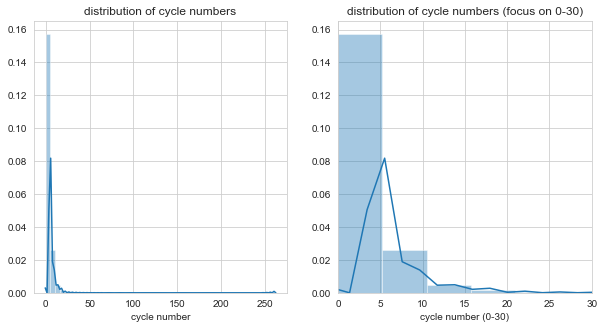

In [88]:
fig4, ax4 = plt.subplots(1,2,figsize=(10,5))
sns.set_style("whitegrid")

ax4[0] = sns.distplot(cycle['CYCLE_NUMBER'], ax=ax4[0])
ax4[0].set_xlabel("cycle number")
ax4[0].set_title("distribution of cycle numbers")

ax4[1] = sns.distplot(cycle['CYCLE_NUMBER'], ax=ax4[1])
ax4[1].set_xlabel("cycle number (0-30)")
ax4[1].set_title("distribution of cycle numbers (focus on 0-30)")
plt.xlim(0, 30)
plt.show()

## Starting PS information

The pie chart below shows the proportion of different performance status of the start. To make the small proportions more visible, a right subplot is ploted showing performance status excluding 0, 1 and 2.

**What I've found:** 
From the pie chart, we can see the most common starting performance status is 0 (Fully active, able to carry on all pre-disease performance without restriction), secondly 1 (Restricted in physically strenuous activity but ambulatory and able to carry out work of a light or sedentary nature) and thirdly 2 (Ambulatory and capable of all selfcare but unable to carry out any work activities; up and about more than 50% of waking hours). Only a few patients start a cycle with performance status 3 (Capable of only limited selfcare; confined to bed or chair more than 50% of waking hours), 4(Capable of only limited selfcare; confined to bed or chair more than 50% of waking hours), 5(dead).

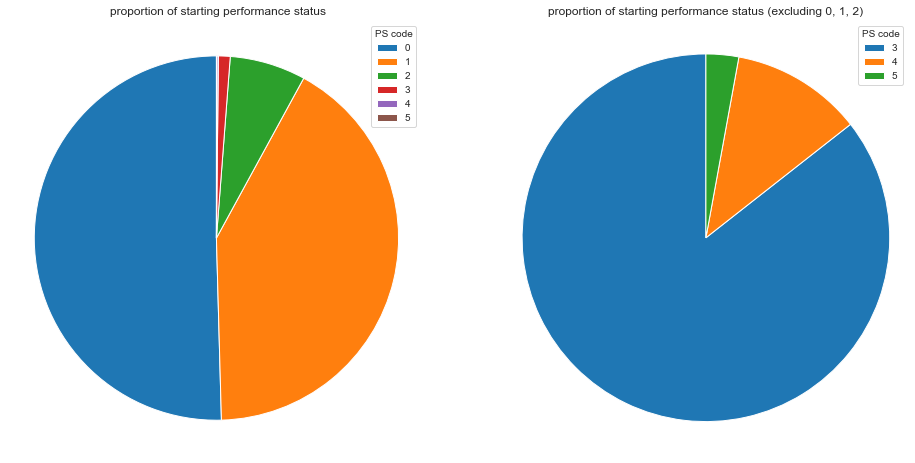

In [89]:
# plot
fig5, ax5 = plt.subplots(1, 2, figsize=(16,8))
explode = (0,0,0,0,0,0)
ax5[0].pie(cycle['PERF_STATUS_START_OF_CYCLE'].value_counts().values,
        explode=explode,
        labels=cycle['PERF_STATUS_START_OF_CYCLE'].value_counts().index,
        shadow = False,
        startangle =90,
        pctdistance = 0.6,
        textprops={'fontsize': 16, 'color':'w'})
ax5[0].legend(cycle['PERF_STATUS_START_OF_CYCLE'].value_counts().index, loc='best', title='PS code')
ax5[0].axis('equal')
ax5[0].set_title("proportion of starting performance status")

explode = (0,0,0)
ax5[1].pie(cycle['PERF_STATUS_START_OF_CYCLE'].value_counts().values[3:],
        explode=explode,
        labels=cycle['PERF_STATUS_START_OF_CYCLE'].value_counts().index[3:],
        shadow = False,
        startangle =90,
        pctdistance = 0.6,
        textprops={'fontsize': 16, 'color':'w'})
ax5[1].legend(cycle['PERF_STATUS_START_OF_CYCLE'].value_counts().index[3:], loc='best', title='PS code')
ax5[1].axis('equal')
ax5[1].set_title("proportion of starting performance status (excluding 0, 1, 2)")
plt.show()

## The relation between cycle numbers and starting PS

The violin plot below shows the relation between cycle numbers and performance status of the start.
The line plot shows the mean of cycle numbers with regard to performance status.

**What I've found:** 
Generally, the cycle numbers of each performance status of the start are around 2. And there is not obvious difference between cycle numbers of different performances status.

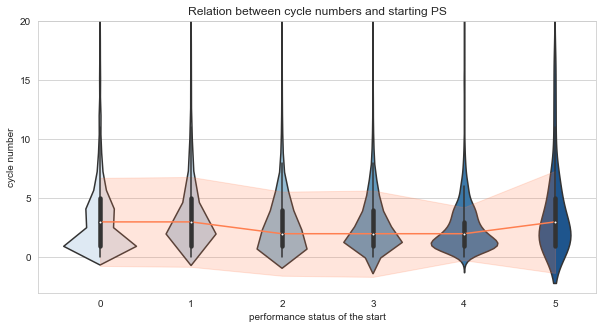

In [90]:
fig6, ax6 = plt.subplots(figsize=(10,5))
sns.set_style("whitegrid")
ax6.set_title("Relation between cycle numbers and starting PS")
ax6 = sns.violinplot(x='PERF_STATUS_START_OF_CYCLE', y='CYCLE_NUMBER', data=cycle, showmean=True, palette="Blues")
plt.ylim(-3, 20)

# plot mean line plot
sns.lineplot(x="PERF_STATUS_START_OF_CYCLE", y="CYCLE_NUMBER", err_style="band", ci='sd', 
             estimator="median", data=cycle, color="coral", ax=ax6)
ax6.set_xlabel("performance status of the start")
ax6.set_ylabel("cycle number")
plt.show()


# Reflect and Hypothesise

## Reflect

While cleaning the data, I found there are some invalid formats and abnormal values. I think this may due to different reasons, such as typos occurred during manually input, false data produced by medical detecting instruments and errors made during transferring data. It is easy to notice those invalid formats and abnormal values, but it is somewhat tricky to redress these values. Because this is the first time I got in touch with these medical terms and jargons, I looked up through NHS website and Pubmed to find the correct interpretation of these concepts and corresponding reference tables. Although holding these references, I still get confused whether I should delete some certain types of entries because they may have meanings in some circumstances. Eventually I chose the best way I supposed to clean this data, trying not to delete entries but transform them into uniform formats.

What I have surprisingly found in this data set is the performance status of the start seems have weak ties with the corresponding cycle number. Before analysing it, I used to think the worse starting performance status people are in, the larger cycle number they may have. Whereas, the truth is not like that. Plus, it also amazes me that most patients starts their cycles in quite good performance status, being fully active or at least being capable to live independently.
 

## Hypothesise

### H1

- What: After cycles, patients' performance status will get worse than the start.
- Why: According to the pie chart showing proportion of starting performance status, most patients start with a quite good psychical condition, so I think they may be in worse performance stauts after definitely cycles which put burden on patients' bodies.
- How: I can combine my analysed data with my group members' data. They have analysed some data related to the ending performance status.

### H2

- What: Normally, the best cycle number is around 5.
- Why: According to the histogram showing distribution of cycle numbers, the most patients received 5 cycles.
- How: I can ask the data holder or find some related studies concerning cycles in cancer.

### H3

- What: Intraaterial is an administration route which demands a big number of dosages.
- Why: According to the bar chart showing average dosage of administration route, Intraaterial is with the highest value.
- How: Firstly, I can ask the data holder if this data are reliable. Then I can turn to further studies, like searching the related medical publications.

### H4

- What: Intravenous is an administration route has the best therapeutic effect on curing cancers.
- Why: According to the pie chart showing proportion of administration routes, Intravenous constitues the biggest proportion.
- How: Because my group members have analysed some data related to the outcome of treatment, I can refer to their analysed data and find the relation between Intravenous and the outcome of treatment.